In [1]:
# Import numpy and matplotlib
from collections import namedtuple
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import simps
from glob import glob
import os
from tqdm import tqdm, trange

# Modify the style of the plots
plt.style.use('seaborn-whitegrid')

In [2]:
datafolder = '../results/'

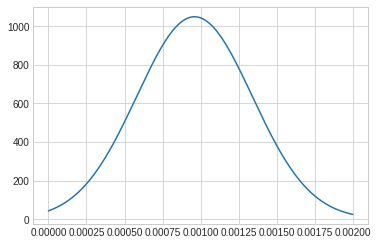

In [3]:
mean_speed = 0.96 * 1e-3
std_dev_speed = 0.38 * 1e-3
Vmin = mean_speed - 2*std_dev_speed
Vmax = mean_speed + 2*std_dev_speed
speed_distribution = lambda v: np.exp(-0.5*((v - mean_speed)/std_dev_speed)**2) / (std_dev_speed*np.sqrt(2*np.pi))

v = np.linspace(0, 2e-3, 1001)
plt.plot(v, speed_distribution(v))

In [4]:
#C = np.load('../results/Case1_K_A_block_Nclasses=128_NJ=4000_dt=60.npy')
C = np.load('../results/Case1_K_A_block_Nclasses=5_NJ=1000_dt=300.npy')
Z, dZ = np.linspace(0, 50, C.shape[-1]+1, retstep=True)
Z = Z[:-1] + dZ/2

plt.plot(Z, C[0,2,:])
plt.plot(Z, C[1,2,:])
plt.plot(Z, C[240,2,:])

print((Z[np.argmax(C[0,2,:])] - Z[np.argmax(C[1,2,:])]) / 3600)

C = np.load('../results/Case1_K_A_block_Nclasses=5_NJ=1000_dt=1200.npy')
Z, dZ = np.linspace(0, 50, C.shape[-1]+1, retstep=True)
Z = Z[:-1] + dZ/2

plt.plot(Z, C[0,2,:])
plt.plot(Z, C[1,2,:])
plt.plot(Z, C[240,2,:])

print((Z[np.argmax(C[0,2,:])] - Z[np.argmax(C[1,2,:])]) / 3600)

FileNotFoundError: [Errno 2] No such file or directory: '../results/Case1_K_A_block_Nclasses=5_NJ=1000_dt=300.npy'

C.shape =  (13, 128, 2000)


(50, 0)

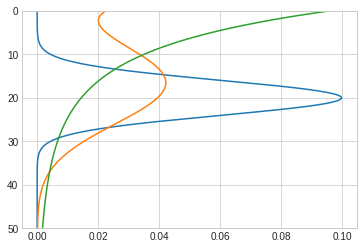

In [4]:
C = np.load('../results/Case1_K_A_block_Nclasses=128_NJ=2000_dt=60.npy')
Z, dZ = np.linspace(0, 50, C.shape[-1]+1, retstep=True)
Z = Z[:-1] + dZ/2
print('C.shape = ', C.shape)

for it in [0, 1, 12]:
    plt.plot(np.sum(C, axis = 1)[it,:], Z)
    
plt.ylim(50, 0)


(0.76, 0.7625)

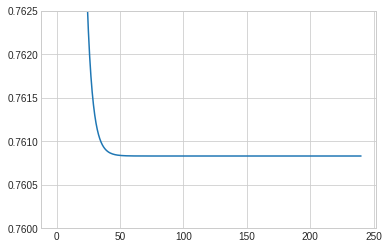

In [113]:
plt.plot(dZ*np.sum(C, axis = (1,2)))

plt.ylim(0.76, 0.7625)


(0, 172800)

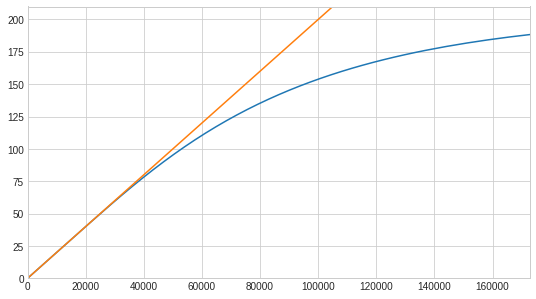

In [86]:
C_norm = C[:,2,:] / np.sum(dZ*C[:,2,:], axis = 1)[:,None]

var = np.sum(dZ*C_norm *(Z-25)**2, axis = 1)

t = np.linspace(0, 240*3600, 241)
K = 1e-3

fig = plt.figure(figsize = (9, 5))
plt.plot(t, var - var[0])
plt.plot(t, 2*K*t)

plt.ylim(0, 210)
plt.xlim(0, 48*3600)

In [88]:
np.var(np.random.uniform(low = 0, high = 50, size = 10000000))

208.38104481212966

# Convergence plots for Case 1 -- Eulerian

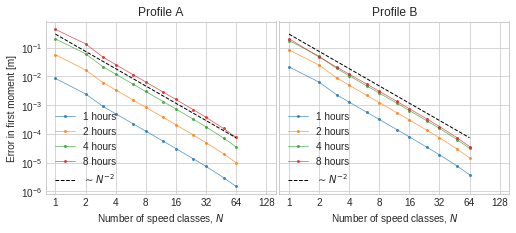

In [9]:
# Total integration time
Tmax = 240*3600
# Max depth of simulation domain
Zmax = 50

# Numerical parameters for reference solution
dt_ref = 60    # Timestep
NJ_ref = 4000  # Number of spatial grid cells
NK_ref = 128   # Number of classes

# Varying numerical parameters
dts = np.array([60, 120, 180, 300, 600, 900, 1800, 3600])
NJs = np.array([4000, 3000, 2000, 1500, 1000, 750, 500, 375, 250, 125])
NKs = np.array([1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64])

# Hours after which to plot the solutions
hours = [1, 2, 4, 8]

fig, ax = plt.subplots(ncols = 2, figsize = (7, 3), sharex = True, sharey = True)
for iplot, profile in enumerate(['A', 'B']):
    
    #### Reference solution  ####
    # Load data, and work out grid parameters
    Cg_ref = np.load(os.path.join(datafolder, f'Case1_K_{profile}_block_Nclasses={NK_ref}_NJ={NJ_ref}_dt={dt_ref}.npy')).sum(axis = 1)
    # Concentration grid cell faces (in z-direction)
    Nt_grid_ref, Nz_grid_ref = Cg_ref.shape
    zc_grid_ref  = np.linspace(0, Zmax, Nz_grid_ref + 1)
    # Concentration grid cell spacing
    dz_grid_ref  = zc_grid_ref[1] - zc_grid_ref[0]
    # Concentration grid cell midpoints
    mid_grid_ref = zc_grid_ref[:-1] + dz_grid_ref/2
        
    errors = [np.zeros(len(NKs)) for h in hours]
    for i, n in enumerate(NKs):

        Cg = np.load(os.path.join(datafolder, f'Case1_K_{profile}_block_Nclasses={n}_NJ={NJs[0]}_dt={dts[0]}.npy')).sum(axis = 1)

        # Concentration grid cells (in z-direction)
        Nt_grid, Nz_grid = Cg.shape
        zc_grid = np.linspace(0, Zmax, Nz_grid + 1)
        dz_grid = zc_grid[1] - zc_grid[0]
        mid_grid = zc_grid[:-1] + dz_grid/2

        for j, h in enumerate(hours):
            ref    = dz_grid_ref * np.sum(mid_grid_ref * Cg_ref[h,:])
            moment = dz_grid     * np.sum(mid_grid     * Cg[h,:])
            errors[j][i] = np.abs(moment - ref)

    for j, h in enumerate(hours):
        ax[iplot].plot(NKs, errors[j][:], marker = '.', markersize = 4, lw = 0.75, alpha = 0.75, label = f'{h} hours')

    ax[iplot].plot(NKs, 0.3*NKs**(-2.0), '--', c = 'k', lw = 1, label = '$\sim N^{-2}$')


    ax[iplot].legend(loc = 'lower left')
    ax[iplot].set_xscale('log')
    ax[iplot].set_yscale('log')

    ticks = [1, 2, 4, 8, 16, 32, 64, 128]
    ax[iplot].set_xticks(ticks)
    ax[iplot].set_xticklabels(ticks)
    ax[iplot].set_xlim(0.8*1, ticks[-1]/0.8)
    ax[iplot].set_title(f'Profile {profile}')

    
ax[0].set_xlabel('Number of speed classes, $N$')
ax[1].set_xlabel('Number of speed classes, $N$')
ax[0].set_ylabel('Error in first moment [m]')

plt.subplots_adjust(left = 0.075, bottom = 0.12, right = 0.995, top = 0.92, wspace =0.015)
#plt.savefig('convergence_Nclasses_case1.pdf')


# Convergence plots for case 2 -- Lagrangian

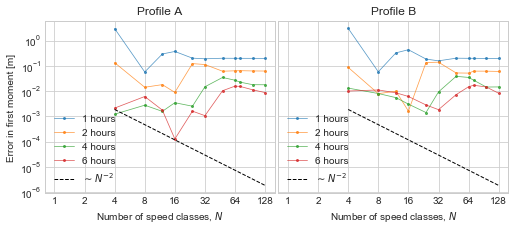

In [46]:
# Total integration time
Tmax = 6*3600
# Max depth of simulation domain
Zmax = 50

# Numerical parameters for reference solution
dt_ref = 1    # Timestep
NJ_ref = 4000  # Number of spatial grid cells
NK_ref = 512   # Number of classes

# Varying numerical parameters
dts = np.array([60, 120, 300])
NJs = np.array([4000])
NKs = np.array([1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 72, 96, 128])
NKs = np.array([4, 8, 12, 16, 24, 32, 48, 64, 72, 96, 128])

# Hours after which to plot the solutions
hours = [1, 2, 4, 6]

fig, ax = plt.subplots(ncols = 2, figsize = (7, 3), sharex = True, sharey = True)
for iplot, profile in enumerate(['A', 'B']):
    
    #### Reference solution  ####
    # Load data, and work out grid parameters
    Cg_ref = np.load(f'../../data/Case2_K_{profile}_block_Nclasses={NK_ref}_NJ={NJ_ref}_dt={dt_ref}.npy').sum(axis = 2)
    # Concentration grid cell faces (in z-direction)
    Nz_grid_ref, Nt_grid_ref = Cg_ref.shape
    zc_grid_ref  = np.linspace(0, Zmax, Nz_grid_ref + 1)
    # Concentration grid cell spacing
    dz_grid_ref  = zc_grid_ref[1] - zc_grid_ref[0]
    # Concentration grid cell midpoints
    mid_grid_ref = zc_grid_ref[:-1] + dz_grid_ref/2
        
    errors = [np.zeros(len(NKs)) for h in hours]
    for i, n in enumerate(NKs):

        Cg = np.load(f'../../data/Case2_K_{profile}_block_Nclasses={n}_NJ={NJ_ref}_dt={dt_ref}.npy').sum(axis = 2)

        # Concentration grid cells (in z-direction)
        Nz_grid, Nt_grid = Cg.shape
        zc_grid = np.linspace(0, Zmax, Nz_grid + 1)
        dz_grid = zc_grid[1] - zc_grid[0]
        mid_grid = zc_grid[:-1] + dz_grid/2

        for j, h in enumerate(hours):
            ref    = dz_grid_ref * np.sum(mid_grid_ref * Cg_ref[:,6*h])
            moment = dz_grid     * np.sum(mid_grid     * Cg[:,6*h])
            errors[j][i] = np.abs(moment - ref)

    for j, h in enumerate(hours):
        ax[iplot].plot(NKs, errors[j][:], marker = '.', markersize = 4, lw = 0.75, alpha = 0.75, label = f'{h} hours')

    ax[iplot].plot(NKs, 0.03*NKs**(-2.0), '--', c = 'k', lw = 1, label = '$\sim N^{-2}$')


    ax[iplot].legend(loc = 'lower left')
    ax[iplot].set_xscale('log')
    ax[iplot].set_yscale('log')

    ticks = [1, 2, 4, 8, 16, 32, 64, 128]
    ax[iplot].set_xticks(ticks)
    ax[iplot].set_xticklabels(ticks)
    ax[iplot].set_xlim(0.8*1, ticks[-1]/0.8)
    ax[iplot].set_title(f'Profile {profile}')

    
ax[0].set_xlabel('Number of speed classes, $N$')
ax[1].set_xlabel('Number of speed classes, $N$')
ax[0].set_ylabel('Error in first moment [m]')

plt.subplots_adjust(left = 0.075, bottom = 0.12, right = 0.995, top = 0.92, wspace =0.015)
plt.savefig('convergence_Nclasses_case2.pdf')


# Convergence plots for Case 1 -- Lagrangian

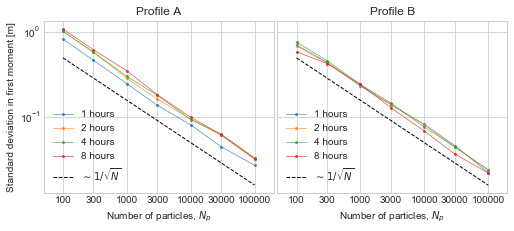

In [28]:
# Total integration time
Tmax = 8*3600
# Max depth of simulation domain
Zmax = 50

# Numerical parameters
dt    = 30    # Timestep
Nruns = 100
Nps   = np.array([100, 300, 1000, 3000, 10000, 30000, 100000])  # Number of particles

# Hours after which to plot the solutions
hours = [1, 2, 4, 8]

# Array to hold data for plotting:
moments = np.zeros((2, len(Nps), len(hours), Nruns))

fig, ax = plt.subplots(ncols = 2, figsize = (7, 3), sharex = True, sharey = True)

for iplot, profile in enumerate(['A', 'B']):
    for n, Np in enumerate(Nps):
        # Files with stored results (first moments)
        datafiles = glob(f'../../data/Case1_K_{profile}_Lagrangian_moment_Np={Np}_dt={dt}_*.npy')

        for i, datafile in enumerate(datafiles):
            data = np.load(datafile)
            for j, hour in enumerate(hours):
                it = int(hour*3600/dt)
                moments[iplot, n, j, i] = data[it]

    for j, hour in enumerate(hours):
        ax[iplot].plot(Nps, np.std(moments[iplot, :, j, :], axis = 1), marker = '.', markersize = 4, lw = 0.75, alpha = 0.75, label = f'{hour} hours')

    ax[iplot].plot(Nps, 5 / np.sqrt(Nps), '--', c = 'k', lw = 1, label = '$\sim 1/\sqrt{N}$')
    
    ax[iplot].legend(loc = 'lower left')
    ax[iplot].set_xscale('log')
    ax[iplot].set_yscale('log')

    ticks = [100, 300, 1000, 3000, 10000, 30000, 100000]
    ax[iplot].set_xticks(ticks)
    ax[iplot].set_xticklabels(ticks)
    ax[iplot].set_xlim(0.5*ticks[0], 2*ticks[-1])
    ax[iplot].set_title(f'Profile {profile}')
    
ax[0].set_xlabel('Number of particles, $N_p$')
ax[1].set_xlabel('Number of particles, $N_p$')
ax[0].set_ylabel('Standard deviation in first moment [m]')

plt.subplots_adjust(left = 0.075, bottom = 0.125, right = 0.995, top = 0.92, wspace =0.015)
plt.savefig('convergence_Nparticles_case1.pdf')

# Convergence plots for Case 2 -- Lagrangian

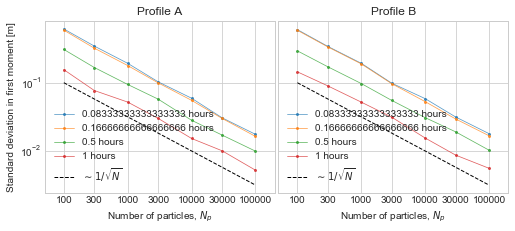

In [18]:
# Total integration time
Tmax = 6*3600
# Max depth of simulation domain
Zmax = 50

# Numerical parameters
dt    = 30    # Timestep
Nruns = 100
Nps   = np.array([100, 300, 1000, 3000, 10000, 30000, 100000])  # Number of particles

# Hours after which to plot the solutions
hours = [5/60, 10/60, 30/60, 1]

# Array to hold data for plotting:
moments = np.zeros((2, len(Nps), len(hours), Nruns))

fig, ax = plt.subplots(ncols = 2, figsize = (7, 3), sharex = True, sharey = True)

for iplot, profile in enumerate(['A', 'B']):
    for n, Np in enumerate(Nps):
        # Files with stored results (first moments)
        datafiles = glob(f'../../data/Case2_K_{profile}_Lagrangian_moment_Np={Np}_dt={dt}_*.npy')

        for i, datafile in enumerate(datafiles):
            data = np.load(datafile)
            for j, hour in enumerate(hours):
                it = int(hour*3600/dt)
                moments[iplot, n, j, i] = data[it]

    for j, hour in enumerate(hours):
        ax[iplot].plot(Nps, np.std(moments[iplot, :, j, :], axis = 1), marker = '.', markersize = 4, lw = 0.75, alpha = 0.75, label = f'{hour} hours')

    ax[iplot].plot(Nps, 1 / np.sqrt(Nps), '--', c = 'k', lw = 1, label = '$\sim 1/\sqrt{N}$')
    
    ax[iplot].legend(loc = 'lower left')
    ax[iplot].set_xscale('log')
    ax[iplot].set_yscale('log')

    ticks = [100, 300, 1000, 3000, 10000, 30000, 100000]
    ax[iplot].set_xticks(ticks)
    ax[iplot].set_xticklabels(ticks)
    ax[iplot].set_xlim(0.5*ticks[0], 2*ticks[-1])
    ax[iplot].set_title(f'Profile {profile}')
    
ax[0].set_xlabel('Number of particles, $N_p$')
ax[1].set_xlabel('Number of particles, $N_p$')
ax[0].set_ylabel('Standard deviation in first moment [m]')

plt.subplots_adjust(left = 0.075, bottom = 0.125, right = 0.995, top = 0.92, wspace =0.015)
plt.savefig('convergence_Nparticles_case2.pdf')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


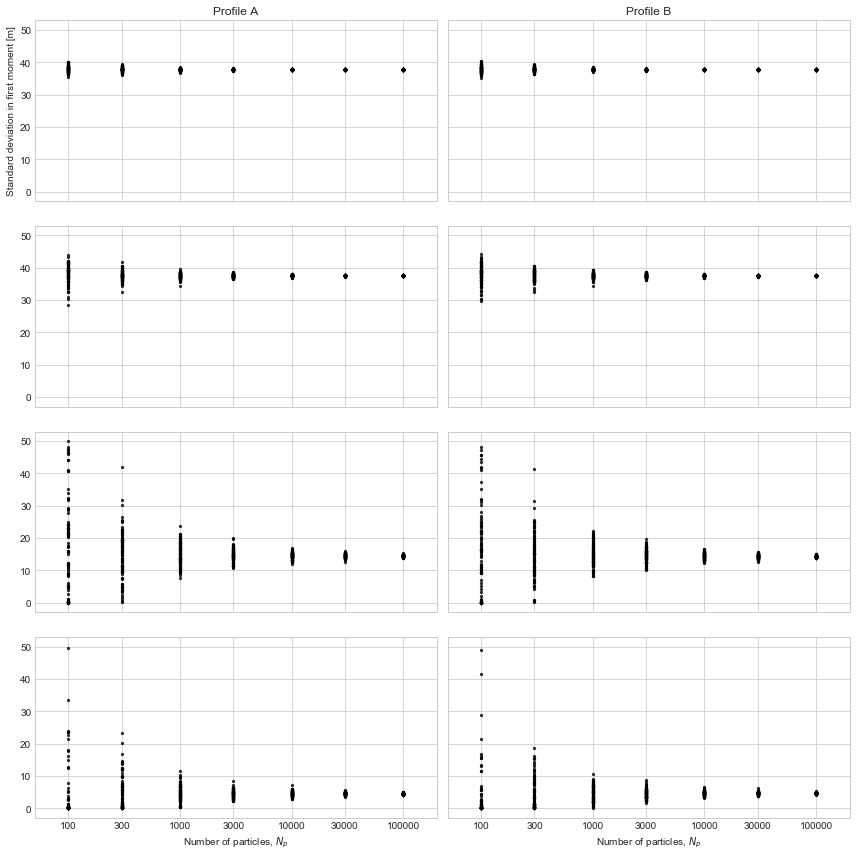

In [46]:
# Total integration time
Tmax = 6*3600
# Max depth of simulation domain
Zmax = 50

# Numerical parameters
dt    = 10    # Timestep
Nruns = 100
Nps   = np.array([100, 300, 1000, 3000, 10000, 30000, 100000])  # Number of particles

# Hours after which to plot the solutions
hours = [5/60, 10/60, 30/60, 1]

# Array to hold data for plotting:
moments = np.zeros((2, len(Nps), len(hours), Nruns))
moments_ref = np.zeros((2, len(hours)))

fig, ax = plt.subplots(ncols = 2, nrows = len(hours), figsize = (12, 12), sharex = True, sharey = True)

for iplot, profile in enumerate(['A', 'B']):
    
    NK_ref = 512
    dt_ref = 1.0
    Cg_ref = np.load(f'../../data/Case2_K_{profile}_block_Nclasses={NK_ref+1}_NJ=4000_dt={dt_ref}.npy').sum(axis=2)
    
    # Concentration grid cells (in z-direction)
    Nz_grid, Nt_grid = Cg_ref.shape
    zc_grid = np.linspace(0, Zmax, Nz_grid + 1)
    dz_grid = zc_grid[1] - zc_grid[0]
    mid_grid = zc_grid[:-1] + dz_grid/2
    times_grid = np.linspace(0, Tmax, Nt_grid)

    for n, Np in enumerate(Nps):
        # Files with stored results (first moments)
        datafiles = glob(f'../../data/Case2_K_{profile}_Lagrangian_moment_Np={Np}_dt={dt}_*.npy')

        for i, datafile in enumerate(datafiles):
            data = np.load(datafile)
            for j, hour in enumerate(hours):
                it = int(hour*3600/dt)
                moments[iplot, n, j, i] = data[it]

    for j, hour in enumerate(hours):
        it = np.argmin(np.abs(times_grid - hour*3600))
        moments_ref[iplot, j] = dz_grid * np.sum(mid_grid * Cg_ref[:,it]) / (dz_grid * np.sum(Cg_ref[:,it]))

        for i in range(len(datafiles)):
            #ax[j,iplot].scatter(Nps, np.abs(moments[iplot, :, j, i] - moments_ref[iplot,j]), marker = '.', s = 20, alpha = 0.75, c = 'k')
            ax[j,iplot].scatter(Nps, moments[iplot, :, j, i], marker = '.', s = 20, alpha = 0.75, c = 'k')

    #ax[iplot].plot(Nps, 1 / np.sqrt(Nps), '--', c = 'k', lw = 1, label = '$\sim 1/\sqrt{N}$')
    
    ax[0,iplot].legend(loc = 'lower left')
    ax[0,iplot].set_xscale('log')
#    ax[0,iplot].set_yscale('log')

    ticks = [100, 300, 1000, 3000, 10000, 30000, 100000]
    ax[0,iplot].set_xticks(ticks)
    ax[0,iplot].set_xticklabels(ticks)
    ax[0,iplot].set_xlim(0.5*ticks[0], 2*ticks[-1])
    ax[0,iplot].set_title(f'Profile {profile}')
    
ax[-1,0].set_xlabel('Number of particles, $N_p$')
ax[-1,1].set_xlabel('Number of particles, $N_p$')
ax[0,0].set_ylabel('Standard deviation in first moment [m]')

plt.tight_layout()
#plt.subplots_adjust(left = 0.075, bottom = 0.125, right = 0.995, top = 0.92, wspace =0.015)
#plt.savefig('convergence_Nparticles_case2.pdf')

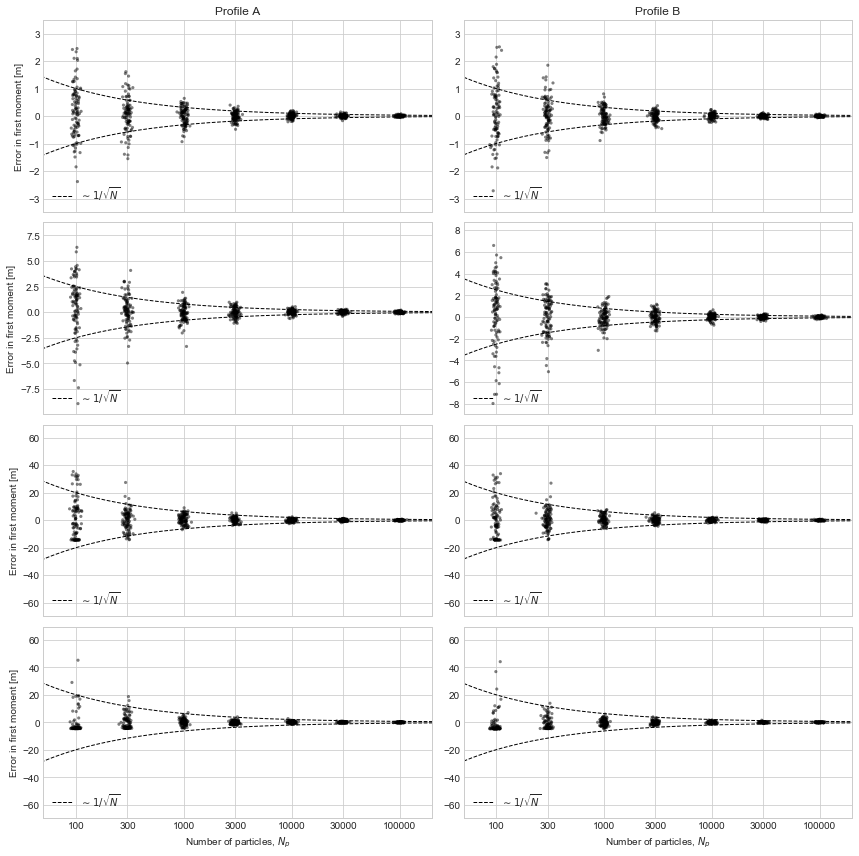

In [60]:
# Total integration time
Tmax = 6*3600
# Max depth of simulation domain
Zmax = 50

# Numerical parameters
dt    = 10    # Timestep
Nruns = 100
Nps   = np.array([100, 300, 1000, 3000, 10000, 30000, 100000])  # Number of particles

# Hours after which to plot the solutions
hours = [5/60, 10/60, 30/60, 1]

# Array to hold data for plotting:
moments = np.zeros((2, len(Nps), len(hours), Nruns))
moments_ref = np.zeros((2, len(hours)))

fig, ax = plt.subplots(ncols = 2, nrows = len(hours), figsize = (12, 12), sharex = True)

for iplot, profile in enumerate(['A', 'B']):
    
    NK_ref = 512
    dt_ref = 1.0
    Cg_ref = np.load(f'../../data/Case2_K_{profile}_block_Nclasses={NK_ref+1}_NJ=4000_dt={dt_ref}.npy').sum(axis=2)
    
    # Concentration grid cells (in z-direction)
    Nz_grid, Nt_grid = Cg_ref.shape
    zc_grid = np.linspace(0, Zmax, Nz_grid + 1)
    dz_grid = zc_grid[1] - zc_grid[0]
    mid_grid = zc_grid[:-1] + dz_grid/2
    times_grid = np.linspace(0, Tmax, Nt_grid)

    for n, Np in enumerate(Nps):
        # Files with stored results (first moments)
        datafiles = glob(f'../../data/Case2_K_{profile}_Lagrangian_moment_Np={Np}_dt={dt}_*.npy')

        for i, datafile in enumerate(datafiles):
            data = np.load(datafile)
            for j, hour in enumerate(hours):
                it = int(hour*3600/dt)
                moments[iplot, n, j, i] = data[it]

    for j, hour in enumerate(hours):
        it = np.argmin(np.abs(times_grid - hour*3600))
        moments_ref[iplot, j] = dz_grid * np.sum(mid_grid * Cg_ref[:,it]) / (dz_grid * np.sum(Cg_ref[:,it]))

        for i in range(len(datafiles)):
            #ax[j,iplot].scatter(Nps, np.abs(moments[iplot, :, j, i] - moments_ref[iplot,j]), marker = '.', s = 20, alpha = 0.75, c = 'k')
            offset = np.random.normal(loc = 0, scale = np.array(Nps/20), size = len(Nps))
            ax[j,iplot].scatter(Nps + offset, moments[iplot, :, j, i] - moments_ref[iplot,j], marker = '.', s = 40, alpha = 0.5, fc = 'k', edgecolor = '')

        tmp = np.logspace(1, 6, 1000)
        prefactors = [10, 25, 200, 200]
        ax[j,iplot].plot(tmp,  prefactors[j] / np.sqrt(tmp), '--', c = 'k', lw = 1, label = '$\sim 1/\sqrt{N}$')
        ax[j,iplot].plot(tmp, -prefactors[j] / np.sqrt(tmp), '--', c = 'k', lw = 1)
    
        ax[j,iplot].legend(loc = 'lower left')
    ax[0,iplot].set_xscale('log')
#    ax[0,iplot].set_yscale('log')

    ticks = [100, 300, 1000, 3000, 10000, 30000, 100000]
    ax[0,iplot].set_xticks(ticks)
    ax[0,iplot].set_xticklabels(ticks)
    ax[0,iplot].set_xlim(0.5*ticks[0], 2*ticks[-1])
    ax[0,iplot].set_title(f'Profile {profile}')
    
ax[-1,0].set_xlabel('Number of particles, $N_p$')
ax[-1,1].set_xlabel('Number of particles, $N_p$')
for i in range(len(hours)):
    ax[i,0].set_ylabel('Error in first moment [m]')

plt.tight_layout()
#plt.subplots_adjust(left = 0.075, bottom = 0.125, right = 0.995, top = 0.92, wspace =0.015)
#plt.savefig('convergence_Nparticles_case2.pdf')

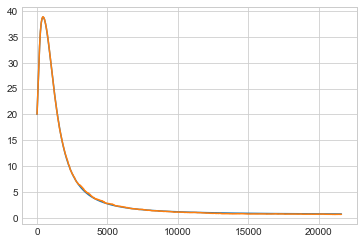

In [39]:
NK_ref = 512
dt_ref = 1.0
profile = 'A'
#Cg_ref = np.load(f'../../data/Case2_K_{profile}_block_Nclasses={NK_ref+1}_NJ=4000_dt={dt_ref}.npy').sum(axis=2)

# Concentration grid cells (in z-direction)
Nz_grid, Nt_grid = Cg_ref.shape
zc_grid = np.linspace(0, Zmax, Nz_grid + 1)
dz_grid = zc_grid[1] - zc_grid[0]
mid_grid = zc_grid[:-1] + dz_grid/2
times_grid = np.linspace(0, Tmax, Nt_grid)

plt.plot(times_grid, dz_grid*np.sum(mid_grid[:,None]*Cg_ref, axis = 0)/(dz_grid*np.sum(Cg_ref, axis = 0)))

moments = np.load('../../data/Case2_K_A_Lagrangian_moment_Np=100000_dt=10_0000.npy')
times_part = np.linspace(0, Tmax, moments.shape[0])
plt.plot(times_part, moments)

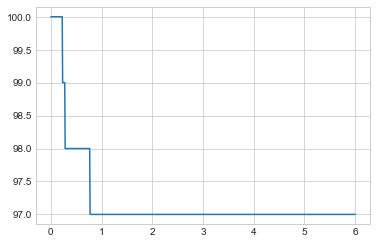

In [28]:
c = np.load('../../data/Case2_K_A_Lagrangian_concentration_Np=100_dt=30_0000.npy')
plt.plot(np.linspace(0, 6*3600, c.shape[0]) / 3600, np.sum(c, axis = 1))

(50, 0)

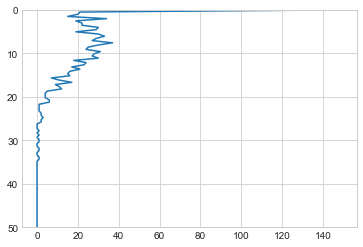

In [29]:
c = np.load('../../data/Case2_K_A_Lagrangian_concentration_Np=1000_dt=30_0000.npy')
plt.plot(c[5,:], np.linspace(0, 50, 100))
plt.ylim(50, 0)

In [17]:
c[500,:]

array([2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
np.histogram(np.zeros(10), bins = np.linspace(0, 1, 10))

(array([10,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]))

361
361


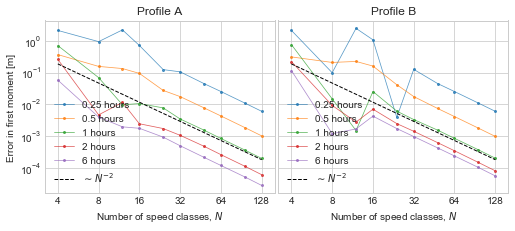

In [61]:
# Total integration time
Tmax = 6*3600
# Max depth of simulation domain
Zmax = 50

# Numerical parameters for reference solution
dt_ref = 1.0    # Timestep
NJ_ref = 4000  # Number of spatial grid cells
NK_ref = 512   # Number of classes

# Varying numerical parameters
dts = np.array([60, 120, 300])
NJs = np.array([4000])
NKs = np.array([1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 72, 96, 128])
NKs = np.array([4, 8, 12, 16, 24, 32, 48, 64, 96, 128])

# Hours after which to plot the solutions
hours = [15/60, 30/60, 1, 2, 6]

fig, ax = plt.subplots(ncols = 2, figsize = (7, 3), sharex = True, sharey = True)
for iplot, profile in enumerate(['A', 'B']):
    
    #### Reference solution  ####
    # Load data, and work out grid parameters
    Cg_ref = np.load(f'../../data/Case2_K_{profile}_block_Nclasses={NK_ref+1}_NJ={NJ_ref}_dt={dt_ref}.npy').sum(axis = 2)
    # Concentration grid cell faces (in z-direction)
    Nz_grid_ref, Nt_grid_ref = Cg_ref.shape
    zc_grid_ref  = np.linspace(0, Zmax, Nz_grid_ref + 1)
    # Concentration grid cell spacing
    dz_grid_ref  = zc_grid_ref[1] - zc_grid_ref[0]
    # Concentration grid cell midpoints
    mid_grid_ref = zc_grid_ref[:-1] + dz_grid_ref/2
    
    print(Nt_grid_ref)
        
    errors = [np.zeros(len(NKs)) for h in hours]
    for i, n in enumerate(NKs):

        Cg = np.load(f'../../data/Case2_K_{profile}_block_Nclasses={n+1}_NJ={NJ_ref}_dt={dt_ref}.npy').sum(axis = 2)

        # Concentration grid cells (in z-direction)
        Nz_grid, Nt_grid = Cg.shape
        zc_grid = np.linspace(0, Zmax, Nz_grid + 1)
        dz_grid = zc_grid[1] - zc_grid[0]
        mid_grid = zc_grid[:-1] + dz_grid/2

        for j, h in enumerate(hours):
            ref    = dz_grid_ref * np.sum(mid_grid_ref * Cg_ref[:,int(60*h)])
            moment = dz_grid     * np.sum(mid_grid     * Cg[:,int(60*h)])
            errors[j][i] = np.abs(moment - ref)

    for j, h in enumerate(hours):
        ax[iplot].plot(NKs, errors[j][:], marker = '.', markersize = 4, lw = 0.75, alpha = 0.75, label = f'{h} hours')

    ax[iplot].plot(NKs, 3*NKs**(-2.0), '--', c = 'k', lw = 1, label = '$\sim N^{-2}$')


    ax[iplot].legend(loc = 'lower left')
    ax[iplot].set_xscale('log')
    ax[iplot].set_yscale('log')

    ticks = [4, 8, 16, 32, 64, 128]
    ax[iplot].set_xticks(ticks)
    ax[iplot].set_xticklabels(ticks)
    ax[iplot].set_xlim(0.8*ticks[0], ticks[-1]/0.8)
    ax[iplot].set_title(f'Profile {profile}')

    
ax[0].set_xlabel('Number of speed classes, $N$')
ax[1].set_xlabel('Number of speed classes, $N$')
ax[0].set_ylabel('Error in first moment [m]')

plt.subplots_adjust(left = 0.075, bottom = 0.12, right = 0.995, top = 0.92, wspace =0.015)
plt.savefig('convergence_Nclasses_case2.pdf')
plt.savefig('convergence_Nclasses_case2.png', dpi = 180)


361


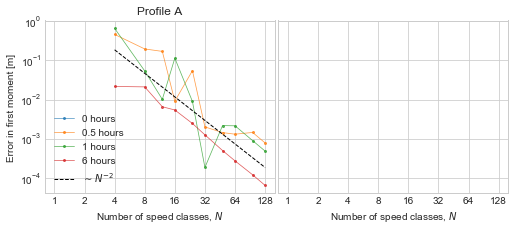

In [16]:
# Total integration time
Tmax = 6*3600
# Max depth of simulation domain
Zmax = 50

# Numerical parameters for reference solution
dt_ref = 1.0    # Timestep
NJ_ref = 4000  # Number of spatial grid cells
NK_ref = 512   # Number of classes

# Varying numerical parameters
dts = np.array([60, 120, 300])
NJs = np.array([4000])
NKs = np.array([1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 72, 96, 128])
NKs = np.array([4, 8, 12, 16, 24, 32, 48, 64, 96, 128])

# Hours after which to plot the solutions
hours = [0, 0.5, 1, 6]

fig, ax = plt.subplots(ncols = 2, figsize = (7, 3), sharex = True, sharey = True)
for iplot, profile in enumerate(['A']):
    
    #### Reference solution  ####
    # Load data, and work out grid parameters
    Cg_ref = np.load(f'../../data/Case2_K_{profile}_block_Nclasses={NK_ref+1}_NJ={NJ_ref}_dt={dt_ref}.npy').sum(axis = 2)
    # Concentration grid cell faces (in z-direction)
    Nz_grid_ref, Nt_grid_ref = Cg_ref.shape
    zc_grid_ref  = np.linspace(0, Zmax, Nz_grid_ref + 1)
    # Concentration grid cell spacing
    dz_grid_ref  = zc_grid_ref[1] - zc_grid_ref[0]
    # Concentration grid cell midpoints
    mid_grid_ref = zc_grid_ref[:-1] + dz_grid_ref/2
    
    print(Nt_grid_ref)
        
    errors = [np.zeros(len(NKs)) for h in hours]
    for i, n in enumerate(NKs):

        Cg = np.load(f'../../data/Case2_K_{profile}_block_Nclasses={n+1}_NJ={NJ_ref}_dt={dt_ref}.npy').sum(axis = 2)

        # Concentration grid cells (in z-direction)
        Nz_grid, Nt_grid = Cg.shape
        zc_grid = np.linspace(0, Zmax, Nz_grid + 1)
        dz_grid = zc_grid[1] - zc_grid[0]
        mid_grid = zc_grid[:-1] + dz_grid/2

        for j, h in enumerate(hours):
            ref    = dz_grid_ref * np.sum(mid_grid_ref * Cg_ref[:,int(60*h)])
            moment = dz_grid     * np.sum(mid_grid     * Cg[:,int(60*h)])
            errors[j][i] = np.abs(moment - ref)

    for j, h in enumerate(hours):
        ax[iplot].plot(NKs, errors[j][:], marker = '.', markersize = 4, lw = 0.75, alpha = 0.75, label = f'{h} hours')

    ax[iplot].plot(NKs, 3*NKs**(-2.0), '--', c = 'k', lw = 1, label = '$\sim N^{-2}$')


    ax[iplot].legend(loc = 'lower left')
    ax[iplot].set_xscale('log')
    ax[iplot].set_yscale('log')

    ticks = [1, 2, 4, 8, 16, 32, 64, 128]
    ax[iplot].set_xticks(ticks)
    ax[iplot].set_xticklabels(ticks)
    ax[iplot].set_xlim(0.8*1, ticks[-1]/0.8)
    ax[iplot].set_title(f'Profile {profile}')

    
ax[0].set_xlabel('Number of speed classes, $N$')
ax[1].set_xlabel('Number of speed classes, $N$')
ax[0].set_ylabel('Error in first moment [m]')

plt.subplots_adjust(left = 0.075, bottom = 0.12, right = 0.995, top = 0.92, wspace =0.015)
plt.savefig('convergence_Nclasses_case2.pdf')
